In [362]:
import os
from dotenv import load_dotenv
load_dotenv()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
from pymongo import MongoClient
import numpy as np

MONGO_PASSWORD = os.environ['MONGO_USER_PASSWORD']
CROWD_TANGLE = os.environ['CROWD_TANGLE_API_TOKEN']

config = {
  'host': '18.216.52.13:27017',
  'username': 'mongo_user',
  'password': MONGO_PASSWORD,
  'authSource': 'reddit_climate_news'
}

db = MongoClient(**config).reddit_climate_news

# Score Distribution

## With Climate Query

In [53]:
posts_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'score': 1}))

In [58]:
posts_df[posts_df.score == 1].shape[0] / posts_df.shape[0]

0.9074155331285652

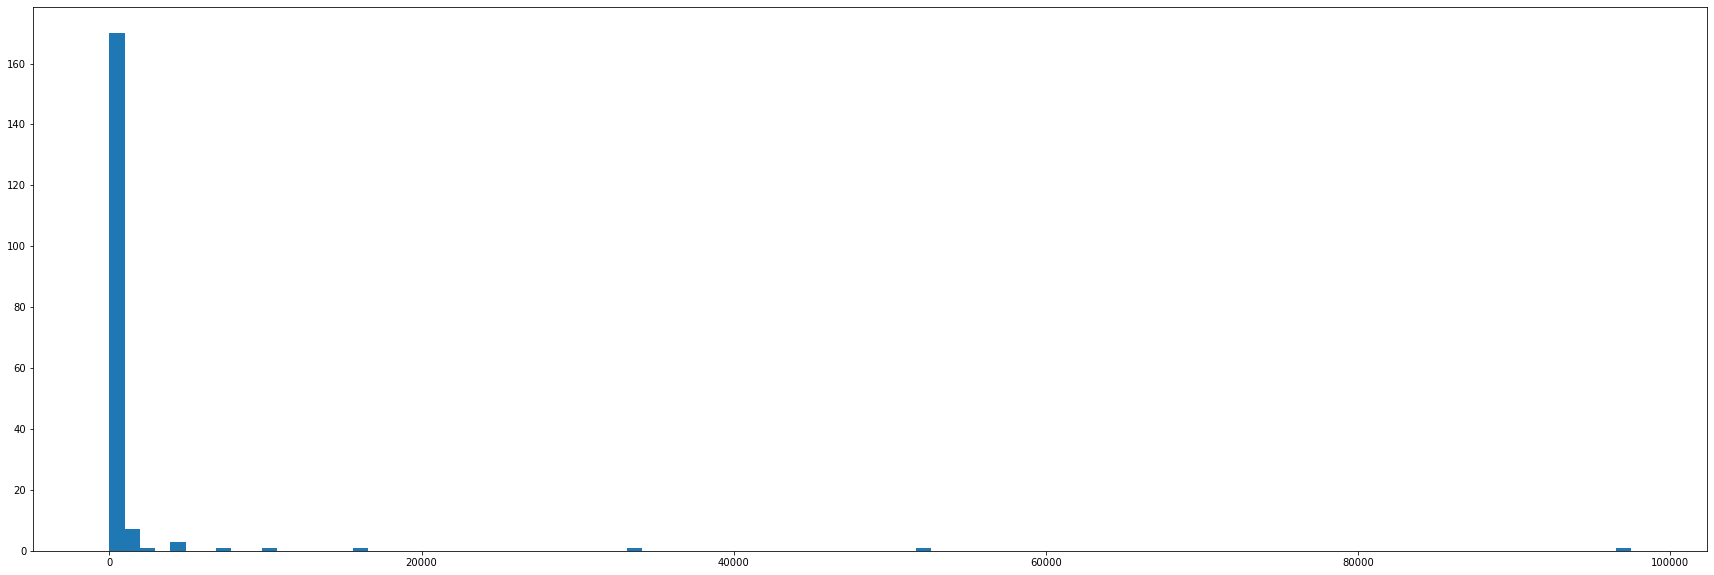

In [69]:
plt.figure(figsize=(30, 10))
plt.hist(posts_df[posts_df.score > 1].score, bins=100);

## All Submissions

In [83]:
all_posts_df = pd.DataFrame.from_records(db.submissions.find({}, {'score': 1}))

In [84]:
all_posts_df[all_posts_df.score == 1].shape[0] / all_posts_df.shape[0]

0.9530127050737688

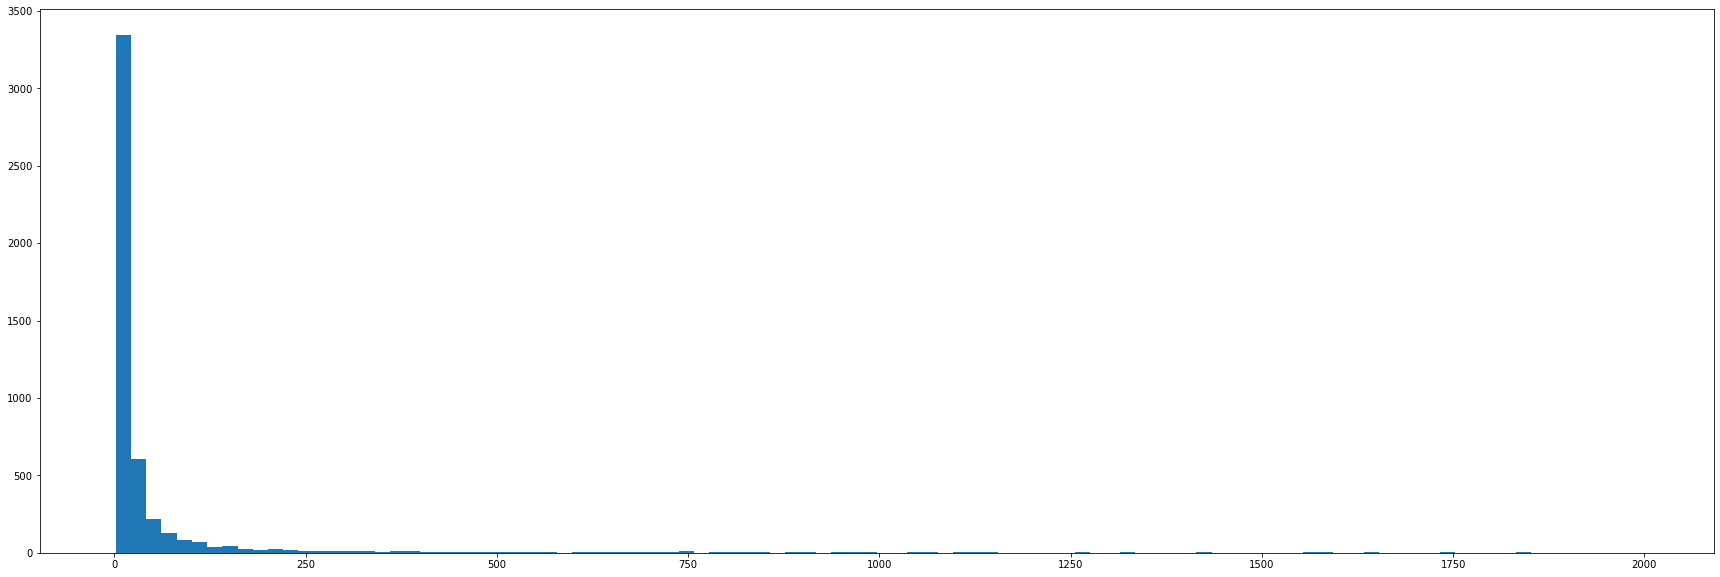

In [88]:
plt.figure(figsize=(30, 10))
plt.hist(all_posts_df[(all_posts_df.score > 1) & (all_posts_df.score < 2000)].score, bins=100);

**Score might be a bad dependent variable**

What if I did number of comments instead?

# Number of Comments

## With Climate Query

In [72]:
num_comm_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'num_comments': 1}))

In [73]:
num_comm_df.describe()

,num_comments
count,2279.000000
mean,85.949978
std,412.053399
min,0.000000
25%,1.000000
50%,4.000000
75%,16.500000
max,6466.000000


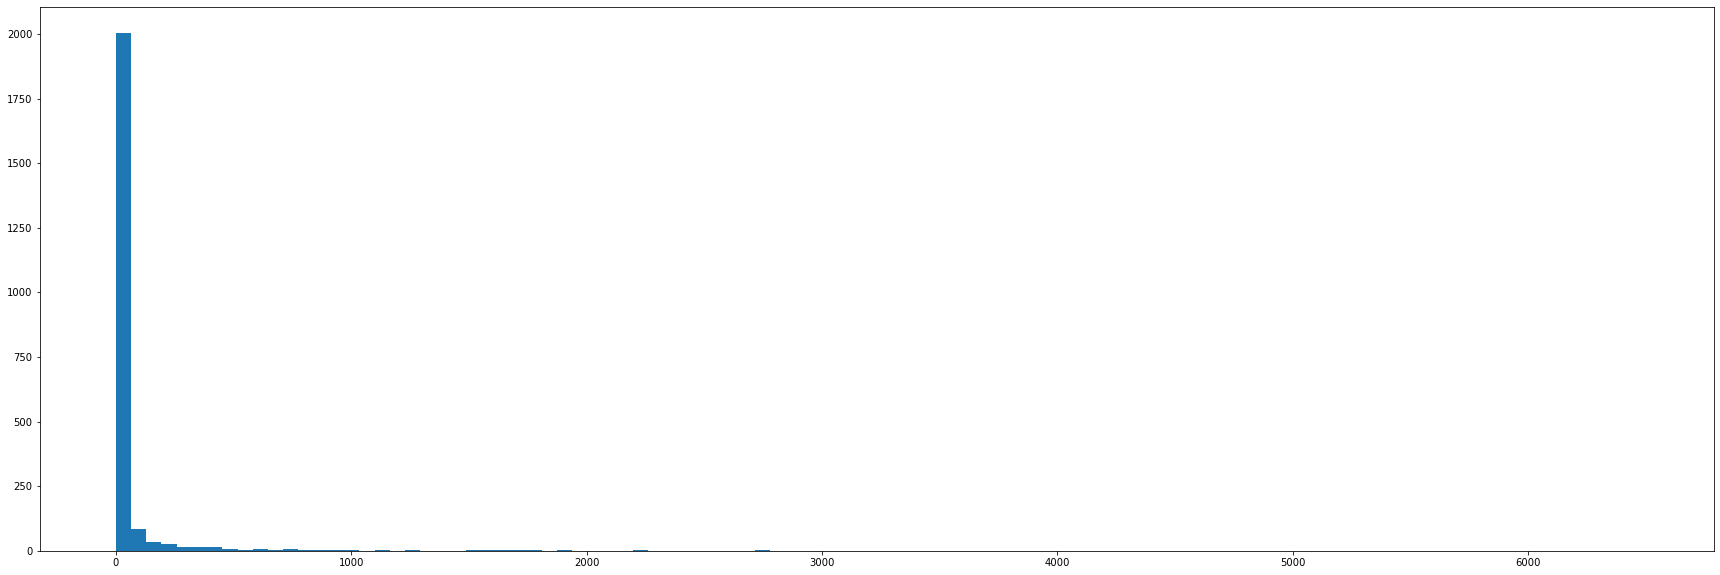

In [75]:
plt.figure(figsize=(30, 10))
plt.hist(num_comm_df.num_comments, bins=100);

## All Submissions

In [89]:
all_comm_df = pd.DataFrame.from_records(db.submissions.find({}, {'num_comments': 1}))

In [90]:
all_comm_df.describe()

,num_comments
count,121054.000000
mean,38.026831
std,406.154310
min,0.000000
25%,0.000000
50%,1.000000
75%,5.000000
max,44762.000000


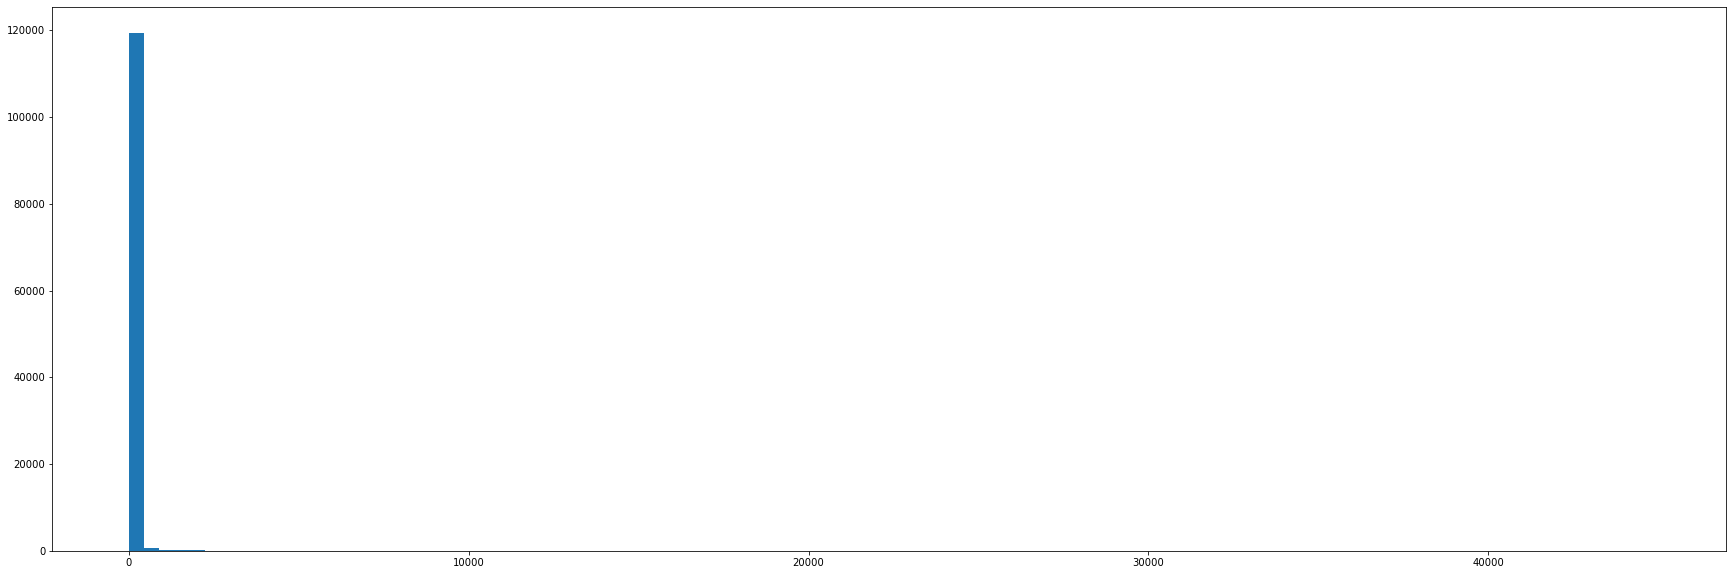

In [91]:
plt.figure(figsize=(30, 10))
plt.hist(all_comm_df.num_comments, bins=100);

In [181]:
both_df = pd.DataFrame.from_records(db.submissions.find({}, {'num_comments': 1, 'score': 1}))

In [183]:
both_df.corr()

,num_comments,score
num_comments,1.000000,0.291983
score,0.291983,1.000000


In [200]:
both_df[both_df.score > 1].corr()

,num_comments,score
num_comments,1.000000,0.594141
score,0.594141,1.000000


# How accurate was the q=climate query?

In [154]:
tr_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'text_razor.response.topics': 1, 'url': 1}))

In [143]:
np.sum(tr_df.text_razor.map(
    lambda tr: len(set(['Global warming', 'Climate change']).intersection(set([x['label'] for x in tr.get('response', {}).get('topics', [])]))) > 0,
    na_action='ignore'))
                                

650

In [ ]:
Greenhouse gas, Carbon dioxide, Climate change, Climate

In [157]:
tr_df.text_razor[0]['response']

{'topics': [{'id': 0,
   'label': 'Agriculture',
   'wikiLink': 'http://en.wikipedia.org/Agriculture',
   'score': 1,
   'wikidataId': 'Q11451'},
  {'id': 1,
   'label': 'Soil',
   'wikiLink': 'http://en.wikipedia.org/Soil',
   'score': 1,
   'wikidataId': 'Q36133'},
  {'id': 2,
   'label': 'Cattle',
   'wikiLink': 'http://en.wikipedia.org/Cattle',
   'score': 1,
   'wikidataId': 'Q830'},
  {'id': 3,
   'label': 'Primary sector of the economy',
   'wikiLink': 'http://en.wikipedia.org/Category:Primary_sector_of_the_economy',
   'score': 1,
   'wikidataId': 'Q55640'},
  {'id': 4,
   'label': 'Natural resources',
   'wikiLink': 'http://en.wikipedia.org/Category:Natural_resources',
   'score': 1,
   'wikidataId': 'Q188460'},
  {'id': 5,
   'label': 'Primary industries',
   'wikiLink': 'http://en.wikipedia.org/Category:Primary_industries',
   'score': 1},
  {'id': 6,
   'label': 'Human activities',
   'wikiLink': 'http://en.wikipedia.org/Category:Human_activities',
   'score': 1},
  {'id': 

In [131]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2279 entries, 0 to 2278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         2279 non-null   object
 1   text_razor  703 non-null    object
dtypes: object(2)
memory usage: 35.7+ KB


In [144]:
650 / 703

0.9246088193456614

In [158]:
tr_df['max_topic_score'] = tr_df.text_razor.map(
    lambda tr: np.max([x['score'] for x in tr.get('response', {}).get('topics', []) if x['label'] in ['Climate change', 'Global warming']], initial=0),
    na_action='ignore')


In [166]:
for url in tr_df[tr_df.max_topic_score > 0].sort_values('max_topic_score').head(20).url:
    print(url)

https://www.abc.net.au/news/2020-01-23/has-australias-climate-switch-been-flicked/11885300?pfmredir=sm
https://www.bbc.com/news/world-africa-51242972
https://www.bbc.com/news/world-africa-51242972
https://www.bbc.co.uk/news/world-africa-51242972
https://www.theguardian.com/business/2020/jan/23/world-bank-chief-david-malpass-davos-snub-dashes-hopes-climate-crisis-consensus
https://www.france24.com/en/20200211-13-activists-held-in-paris-over-storming-of-blackrock-offices
https://www.theguardian.com/global-development/2020/jan/27/mogadishu-left-reeling-as-climate-and-conflict-spark-rural-exodus
https://www.nydailynews.com/news/national/ny-doomsday-clock-20200123-a4fuynnpkjadjih3vkn5eds5r4-story.html
https://africabusinesscommunities.com/agribusiness/news/southern-africa-in-throes-of-climate-emergency-45-million-people-facing-hunger-across-the-region-wfp/
https://www.rollingstone.com/politics/politics-news/trump-davos-speech-world-economic-forum-940280/
https://www.positive.news/society/ed

**Visual inspection confirms that the vast majority of the articles are about climate change even if the TextRazor score is low**

What about the 53 that TextRazor doesn't label either Global warming or Climate change?

In [170]:
for url in tr_df[~tr_df.text_razor.isnull() & (tr_df.max_topic_score == 0)].url:
    print(url)

https://www.thenation.com/article/greta-thunberg-climate-change-strike/
https://www.thenation.com/article/greta-thunberg-climate-change-strike/
https://www.thenation.com/article/greta-thunberg-climate-change-strike/
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt


**Visual inspection of the 53 suggests they are also about climate change**

So I can probably rely on the q=climate to get topically articles. So only need text razor if the granular topics are predictive of score/comments etc.

For now, can probably try to do the analysis without it

In [173]:
top_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'score': 1, 'url': 1, 'num_comments': 1}))

In [178]:
for url in top_df.sort_values('score', ascending=False).head(20).url:
    print(url)

https://www.independent.co.uk/environment/climate-emergency-scientists-emissions-letter-climate-change-a9185786.html
https://www.cnbc.com/2019/11/05/elizabeth-warren-slams-twitter-for-ban-on-ads-tied-to-climate-change.html
https://www.newsweek.com/trump-paris-climate-change-agreement-governors-republican-democrat-1469769
https://edition.cnn.com/2019/11/06/asia/new-zealand-ok-boomer-trnd/index.html
https://www.businessinsider.com/google-employees-are-demanding-the-company-cut-ties-with-climate-change-deniers-2019-11
https://www.reuters.com/article/us-climate-change-italy-exclusive/exclusive-italy-to-make-climate-change-study-compulsory-in-schools-idUSKBN1XF1E1?utm_source=reddit.com
https://www.washingtonpost.com/world/2019/11/01/australias-prime-minister-pledges-outlaw-climate-boycotts-arguing-they-threaten-economy/
https://www.cnbc.com/2020/01/02/amazon-threatens-to-fire-employees-who-speak-out-on-climate-change.html
https://news.yahoo.com/australia-pm-vows-outlaw-apocalyptic-climate-a

**Visual inspection of highest scoring articles confirms about climate change**

In [179]:
for url in top_df.sort_values('num_comments', ascending=False).head(20).url:
    print(url)

https://www.independent.co.uk/environment/climate-emergency-scientists-emissions-letter-climate-change-a9185786.html
https://www.independent.co.uk/environment/greta-thunberg-climate-change-rest-protest-trump-bolsonaro-turin-environment-a9246641.html
https://www.reuters.com/article/us-australia-wildfires-climate-change-an/scientists-paint-australia-fires-as-red-alert-on-climate-change-idUSKBN1ZB00Y?utm_source=reddit.com
https://www.independent.co.uk/environment/australia-heatwave-weather-forecast-warnings-climate-crisis-scott-morrison-a9248376.html?amp
https://www.vanityfair.com/news/2019/12/melania-trump-greta-thunberg
https://www.theglobeandmail.com/world/article-australias-leaders-unmoved-on-climate-action-after-devastating-2/
https://metro.co.uk/2019/11/30/sir-david-attenborough-says-late-reverse-climate-change-11244918/
https://www.reuters.com/article/us-climate-change-thunberg-idUSKBN1YY0PV
https://theweek.com/speedreads/888638/trump-now-says-climate-change-serious-not-hoax
https:

**Visual inspection of highest comment articles confirms about climate change**

# How many duplicate posts are there?

In [226]:
url_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'url': 1, 'id': 1, 'score': 1, 'num_comments': 1}))

In [211]:
url_counts = url_df.url.value_counts()

In [214]:
np.sum(url_counts[url_counts > 1]) - len(url_counts[url_counts > 1])

473

In [213]:
np.sum(url_counts)

2279

In [216]:
473 / 2279
# 20% of posts are duplicates -> I wonder if this skews results?

0.20754716981132076

In [229]:
url_counts = url_df[url_df.score > 1].url.value_counts()
np.sum(url_counts[url_counts > 1]) - len(url_counts[url_counts > 1])
# But very few duplicates have a score > 1

24

**If I take the highest of the duplicates according to metric, should be fine**

# How is distribution of dependent variables changed if I remove dups?

In [217]:
expl_drop_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'url': 1, 'id': 1, 'score': 1, 'num_comments': 1}))

In [232]:
dedup_df = expl_drop_df.sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

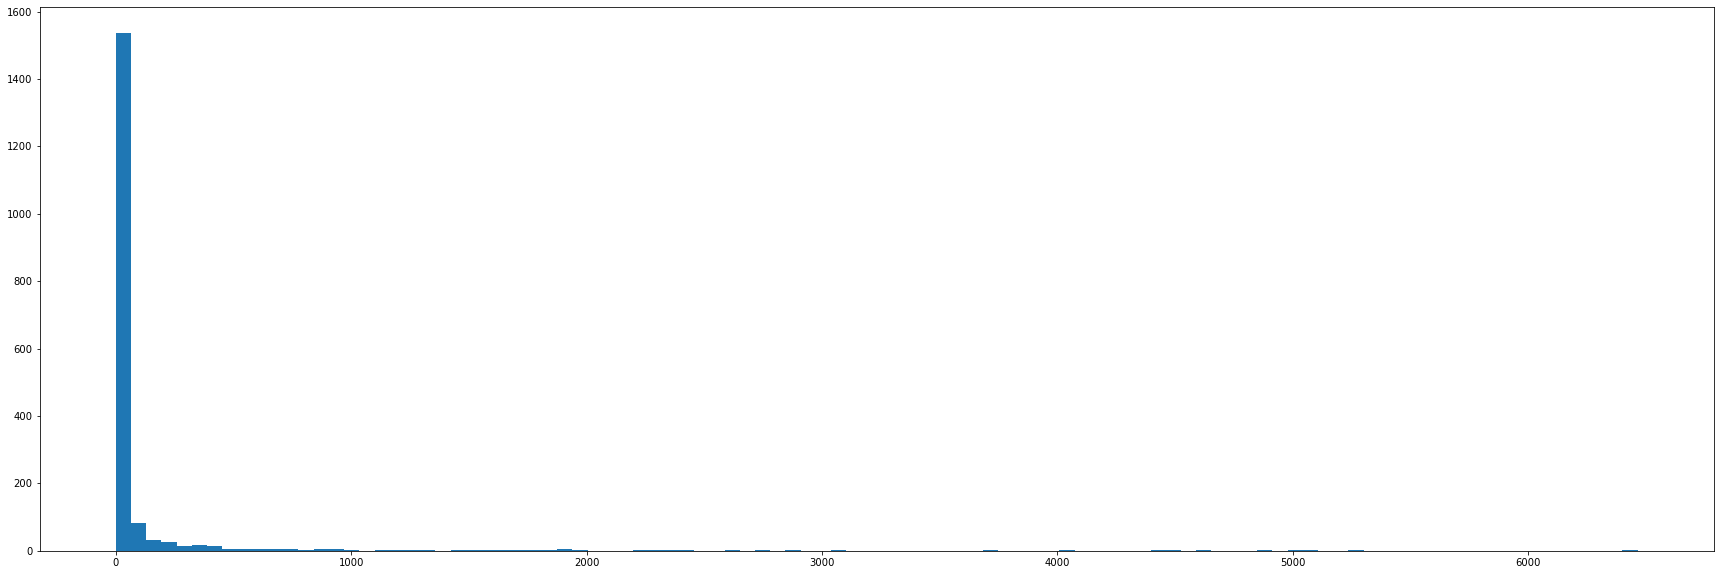

In [234]:
plt.figure(figsize=(30, 10))
plt.hist(dedup_df.num_comments, bins=100);

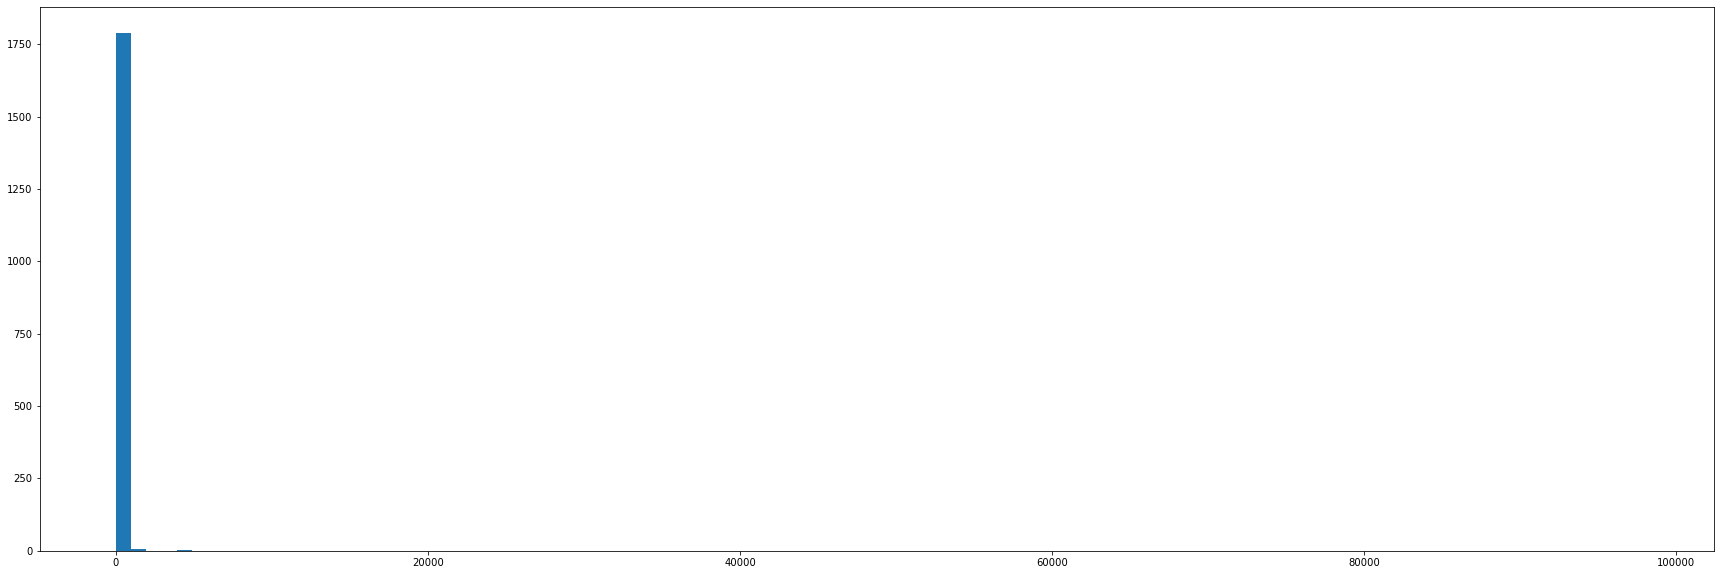

In [235]:
plt.figure(figsize=(30, 10))
plt.hist(dedup_df.score, bins=100);

**Slightly Improved (still kinda sucks)**

Num Comments seems like a slightly better explanatory variable

# Facebook Data

In [79]:
ct_records = [
    { **x['crowd_tangle']['result']['interactions'], 'id': x['id'], 'score': x['score'], 'url': x['url'], 'num_comments': x['num_comments']} for x
    in db.climate_submissions.find({'crowd_tangle.result': {'$exists': True}}, {'id': 1, 'score': 1, 'crowd_tangle': 1, 'url': 1, 'num_comments': 1})]


In [247]:
ct_df = pd.DataFrame.from_records(ct_records).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [249]:
ct_df.corr()

,facebookInteractionCount,reactionCount,commentCount,shareCount,score,num_comments
facebookInteractionCount,1.000000,0.995998,0.899643,0.938207,-0.001109,0.137733
reactionCount,0.995998,1.000000,0.865654,0.926151,-0.002621,0.131253
commentCount,0.899643,0.865654,1.000000,0.784293,0.001798,0.174350
shareCount,0.938207,0.926151,0.784293,1.000000,0.004155,0.101445
score,-0.001109,-0.002621,0.001798,0.004155,1.000000,0.035051
num_comments,0.137733,0.131253,0.174350,0.101445,0.035051,1.000000


**Some relationship between FB interaction and Reddit comments**

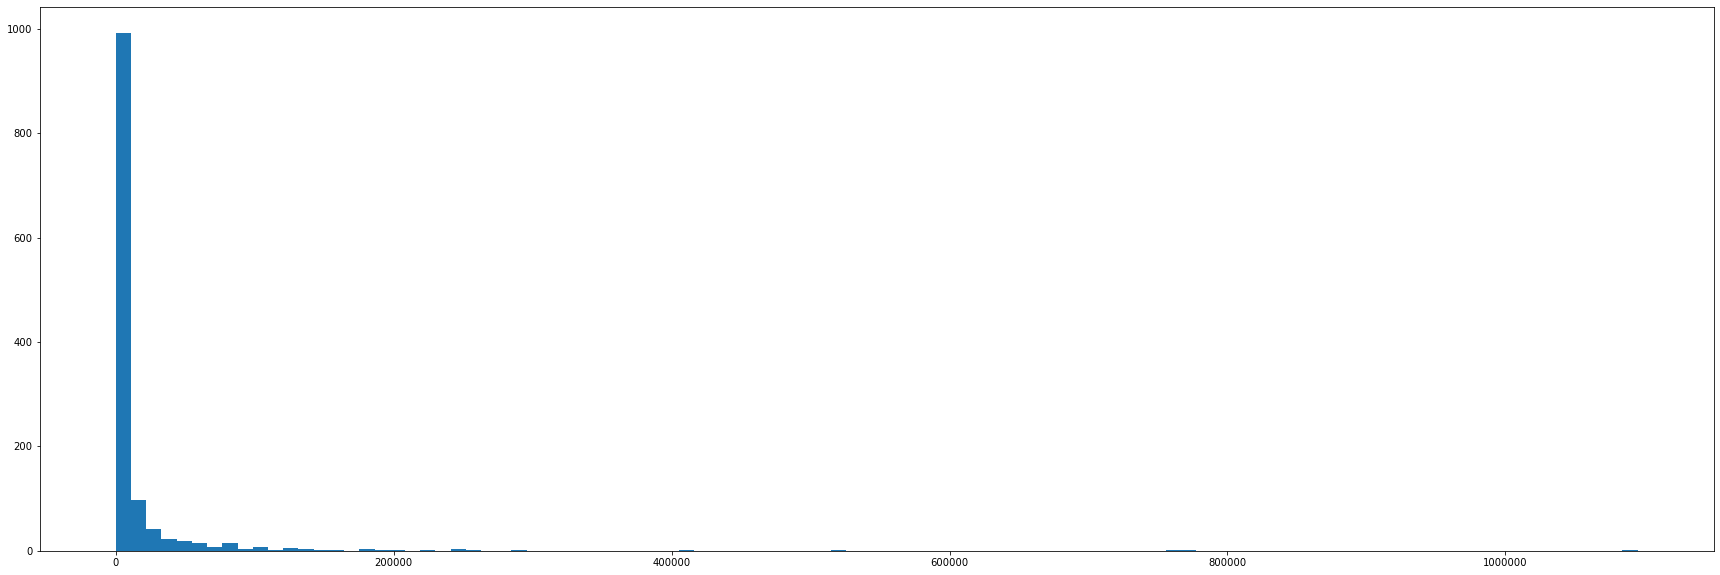

In [251]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.facebookInteractionCount, bins=100);

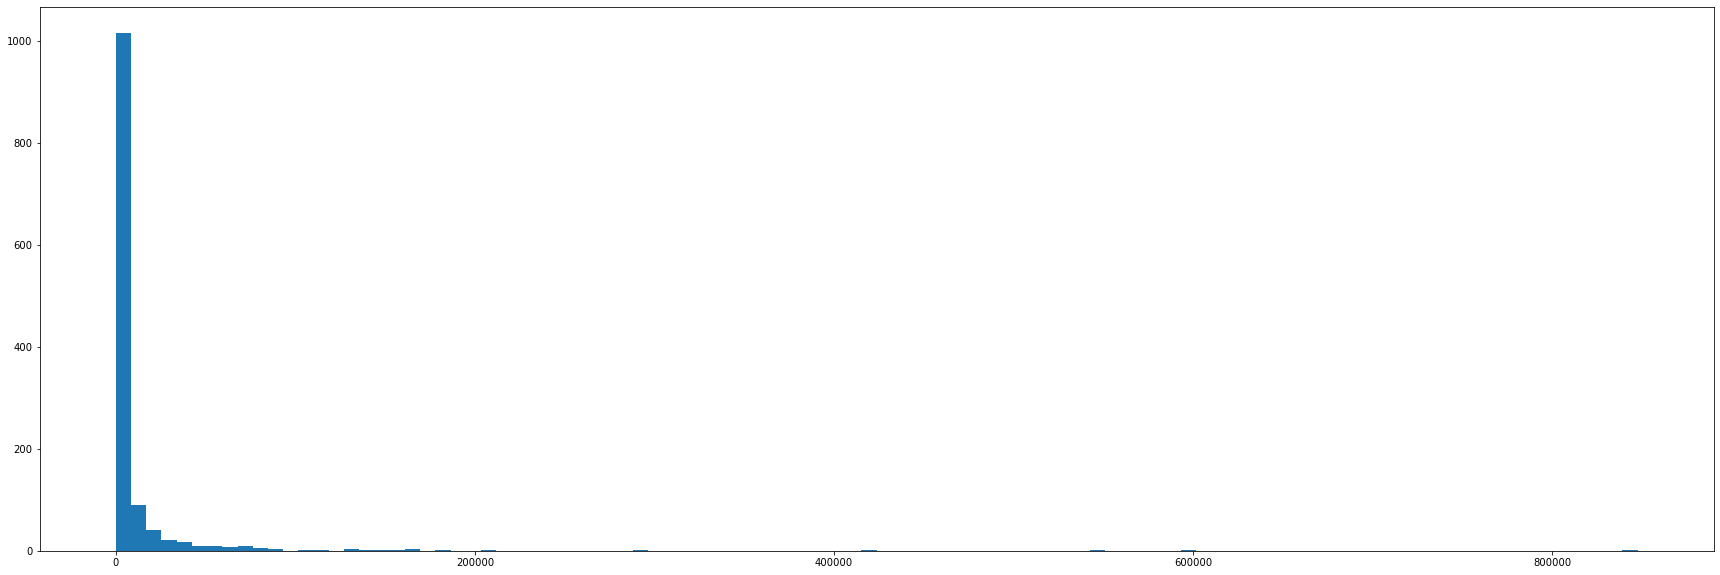

In [252]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.reactionCount, bins=100);

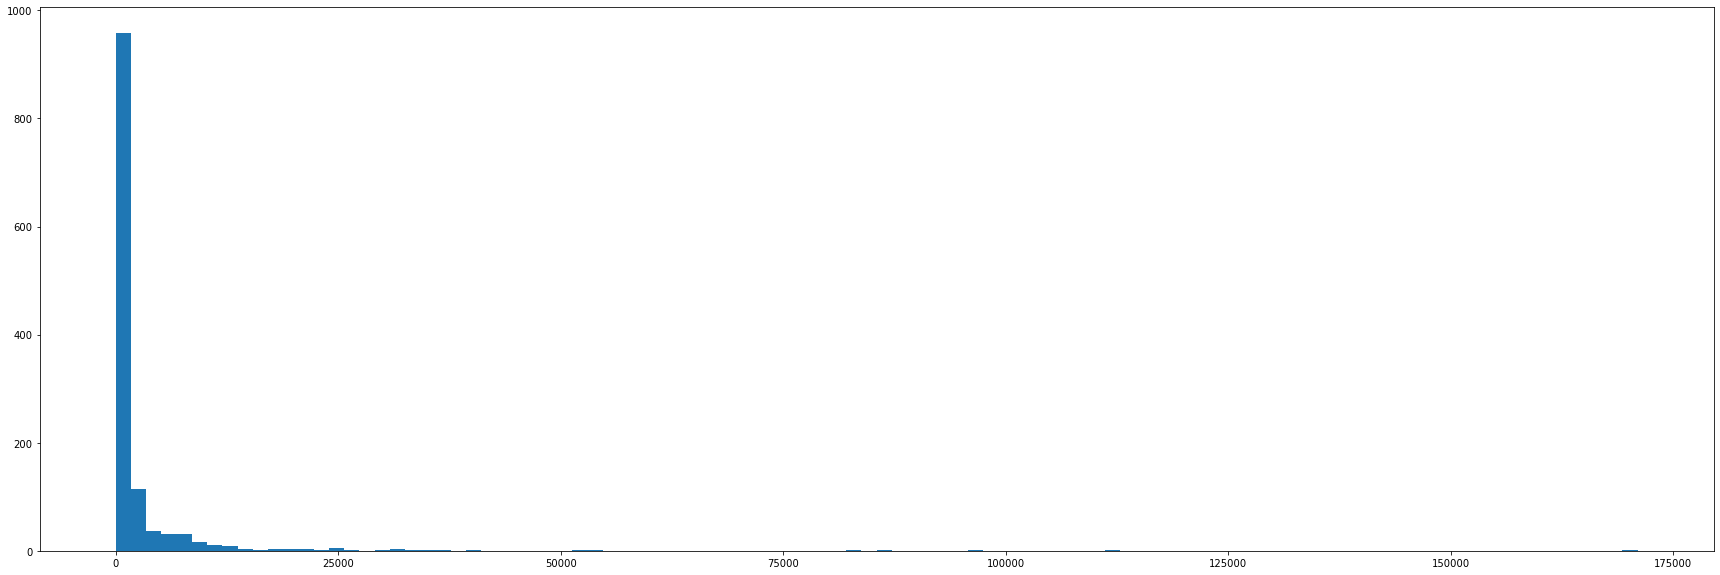

In [253]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.commentCount, bins=100);

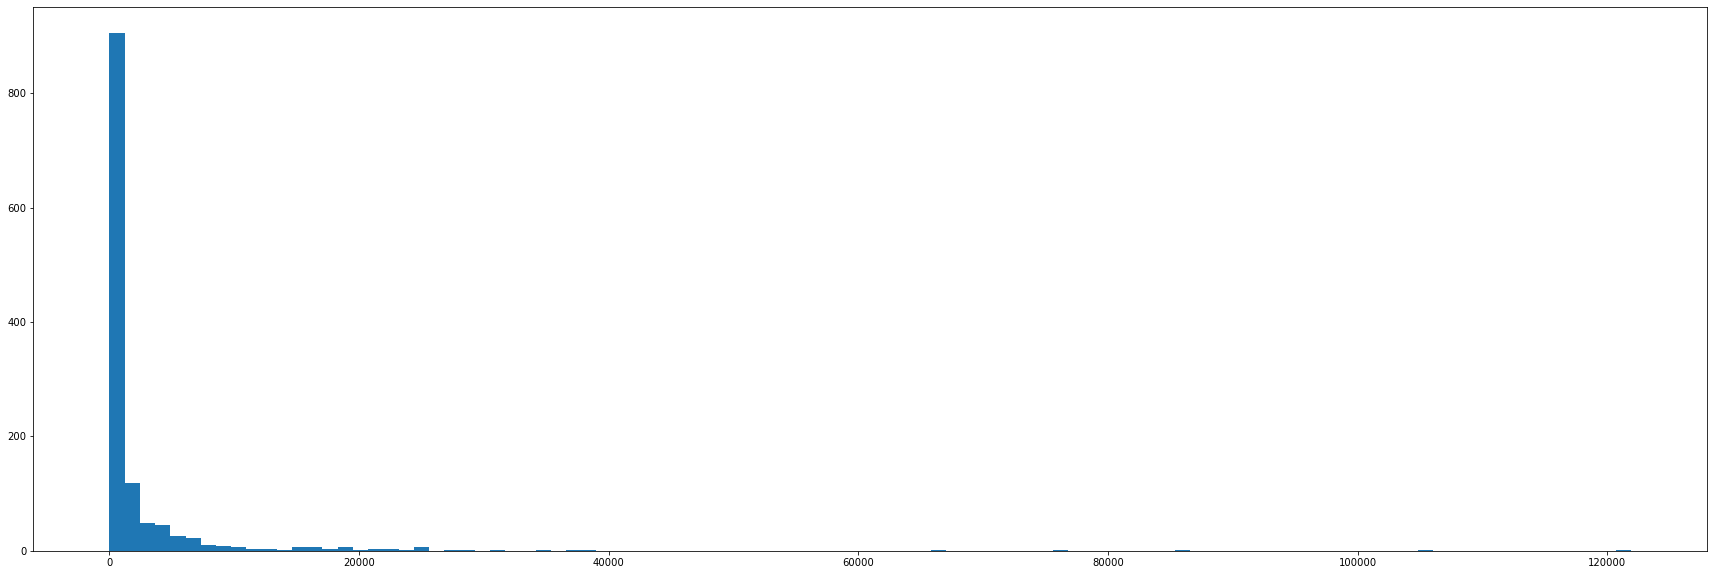

In [254]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.shareCount, bins=100);

**Probably pick one FB metric (probably comments -> highest corr)**

# Sentiment and Tone

In [280]:
sent_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1, 'sentiment_score': 1, 'tone_analyzer': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

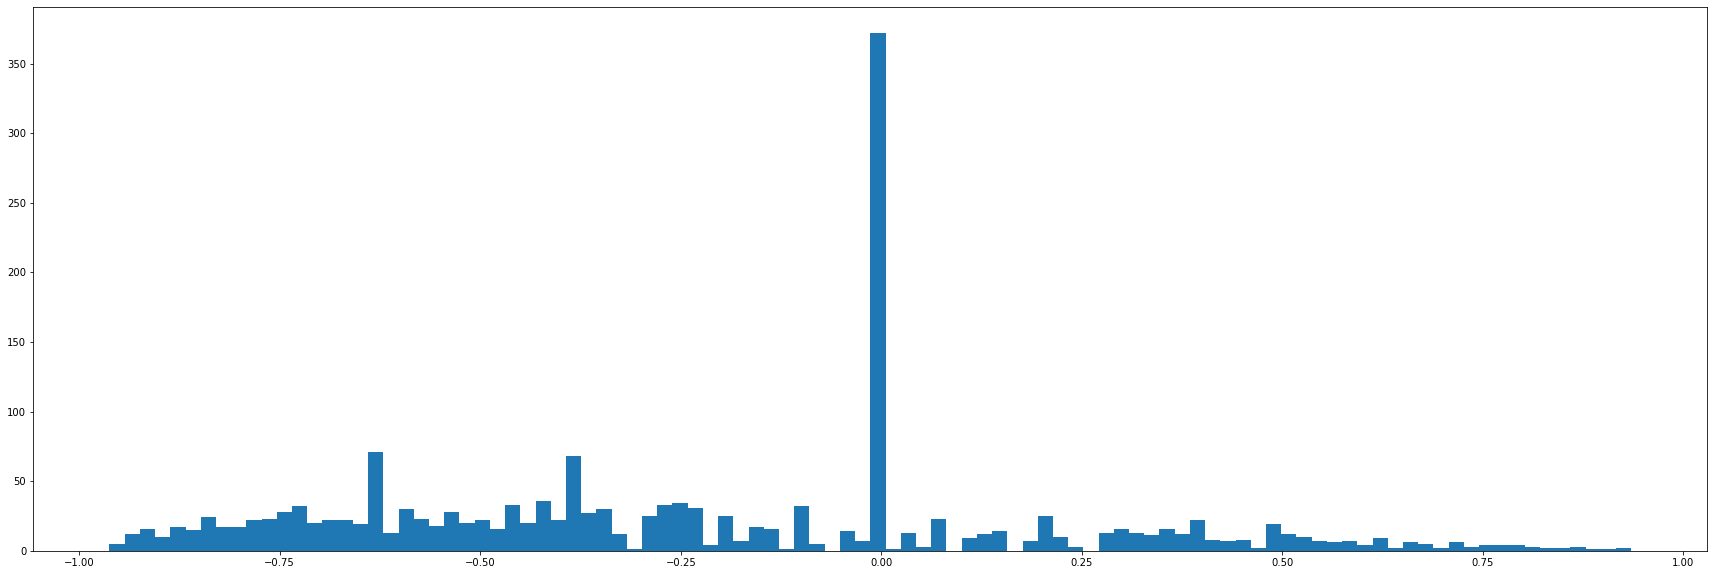

In [281]:
plt.figure(figsize=(30, 10))
plt.hist(sent_df.sentiment_score, bins=100);

In [282]:
sent_df.corr()

,num_comments,score,sentiment_score
num_comments,1.000000,0.365852,-0.045247
score,0.365852,1.000000,-0.031750
sentiment_score,-0.045247,-0.031750,1.000000


**Sentiment of the title has very little predictive power**

In [283]:
tone_df = sent_df[~sent_df.tone_analyzer.isnull()]

In [286]:
def extract_score_from_tones(tones, tone_id):
    """
    Extracts specific tone score from array of tone values

    Args:
        tones (list): List of tone objects from IBM tone API
        tone_id (str): specific tone id

    Returns:
        Score as float if it exists. NaN if not.
    """
    matching_tones = [t for t in tones if t['tone_id'] == tone_id]

    if not matching_tones:
        return np.nan

    return matching_tones[0]['score']

def extract_score(raw_tone, tone_id):
    """
    Extracts specific tone score from raw tone API response

    Args:
        raw_tone (obj): Raw response object from IBM tone API
        tone_id (str): specific tone id

    Returns:
        Score as float if it exists. NaN if not.
    """
    if not raw_tone.get('document_tone'):
        return np.nan

    tones = raw_tone.get('document_tone').get('tones')
    return extract_score_from_tones(tones, tone_id)

In [287]:
extract_score(tone_df.tone_analyzer[0], 'sadness')

0.5383

In [288]:
for t in ['analytical', 'anger', 'confident', 'fear', 'joy', 'sadness', 'tentative']:
    tone_df[t] = tone_df.tone_analyzer.map(lambda ta: extract_score(ta, t))

In [289]:
tone_df.corr()

,num_comments,score,sentiment_score,analytical,anger,confident,fear,joy,sadness,tentative
num_comments,1.000000,0.365852,-0.045247,-0.009717,0.010183,-0.137431,-0.078975,0.125040,0.068902,-0.156760
score,0.365852,1.000000,-0.031750,0.047610,-0.124516,-0.006808,-0.060645,-0.136021,0.110920,0.059865
sentiment_score,-0.045247,-0.031750,1.000000,0.004262,-0.152226,0.014938,-0.176815,0.204716,-0.192500,0.080110
analytical,-0.009717,0.047610,0.004262,1.000000,-0.312411,0.050405,0.170658,-0.077937,-0.060098,0.114762
anger,0.010183,-0.124516,-0.152226,-0.312411,1.000000,-0.998636,1.000000,NaN,NaN,-0.856423
confident,-0.137431,-0.006808,0.014938,0.050405,-0.998636,1.000000,0.332074,-0.153151,0.145328,NaN
fear,-0.078975,-0.060645,-0.176815,0.170658,1.000000,0.332074,1.000000,NaN,0.731528,-0.072021
joy,0.125040,-0.136021,0.204716,-0.077937,NaN,-0.153151,NaN,1.000000,NaN,0.246691
sadness,0.068902,0.110920,-0.192500,-0.060098,NaN,0.145328,0.731528,NaN,1.000000,-0.070160
tentative,-0.156760,0.059865,0.080110,0.114762,-0.856423,NaN,-0.072021,0.246691,-0.070160,1.000000


In [290]:
tone_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1806 entries, 2181 to 368
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   _id              1806 non-null   object 
 1   num_comments     1806 non-null   int64  
 2   score            1806 non-null   int64  
 3   url              1806 non-null   object 
 4   sentiment_score  1806 non-null   float64
 5   tone_analyzer    1806 non-null   object 
 6   analytical       650 non-null    float64
 7   anger            52 non-null     float64
 8   confident        136 non-null    float64
 9   fear             246 non-null    float64
 10  joy              114 non-null    float64
 11  sadness          204 non-null    float64
 12  tentative        210 non-null    float64
dtypes: float64(8), int64(2), object(3)
memory usage: 277.5+ KB


**Get some corr from the tones but relatively few of the articles have it**

anger/tentative, confident/joy/sadness

Prob anger and joy

# Length of Article

In [308]:
length_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {'text_razor': {'$exists': True}},
        {'score': 1, 'num_comments': 1, 'url': 1, 'text_razor': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [309]:
# remove errors
length_df = length_df[length_df.text_razor.map(lambda tr: type(tr) != str)]

In [313]:
length_df['article_length'] = length_df.text_razor.map(lambda tr: len(tr.get('response', {}).get('cleanedText', '')), na_action='ignore')

In [327]:
length_df[length_df.article_length > 10000].corr()

,num_comments,score,article_length
num_comments,1.000000,0.046697,0.269217
score,0.046697,1.000000,-0.059554
article_length,0.269217,-0.059554,1.000000


In [325]:
length_df[length_df.article_length < 5000].corr()

,num_comments,score,article_length
num_comments,1.000000,0.011697,0.091233
score,0.011697,1.000000,0.018789
article_length,0.091233,0.018789,1.000000


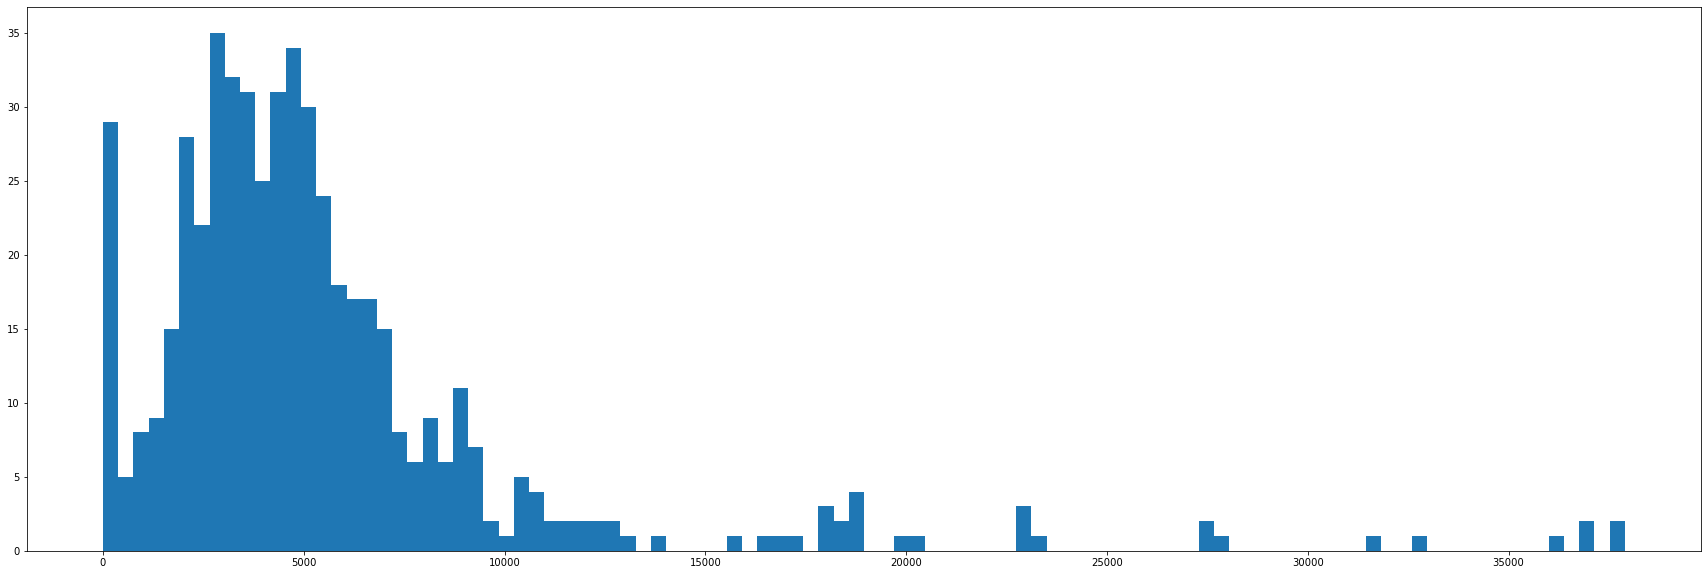

In [316]:
plt.figure(figsize=(30, 10))
plt.hist(length_df[length_df.article_length < 40000].article_length, bins=100);

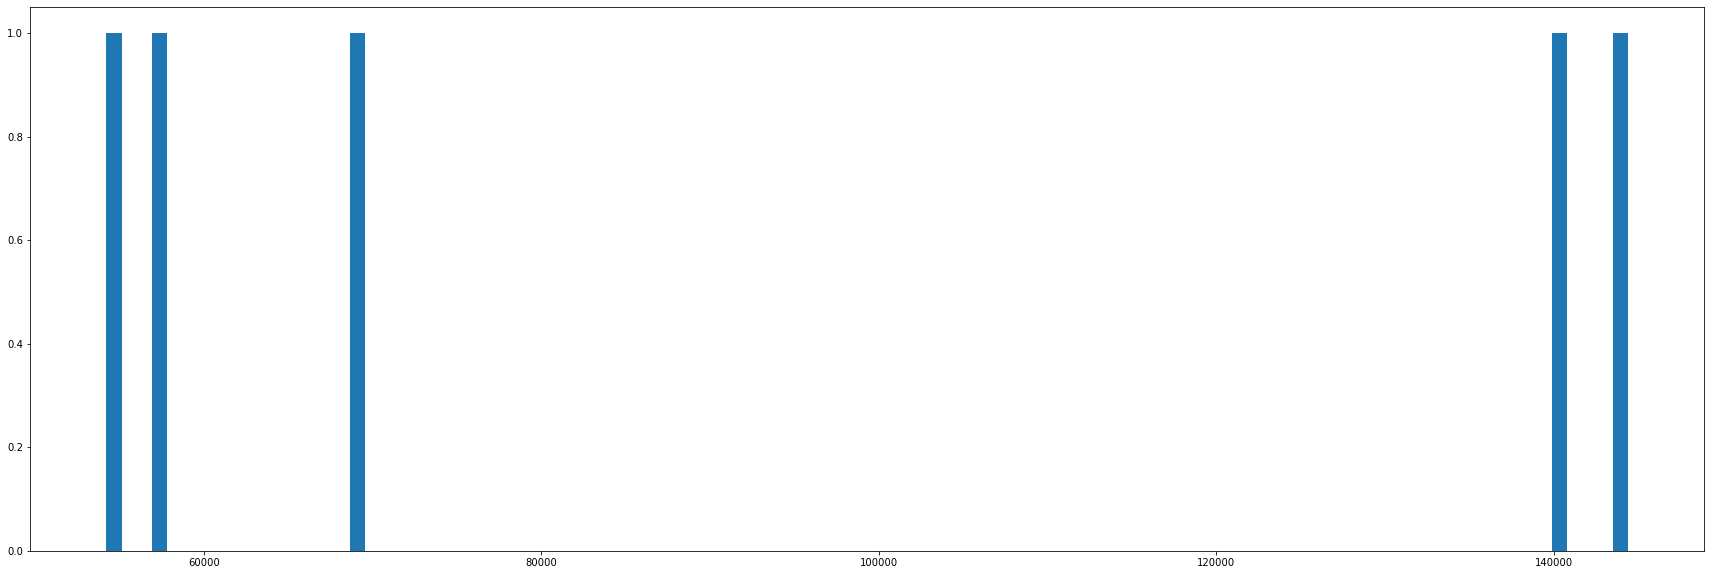

In [320]:
plt.figure(figsize=(30, 10))
plt.hist(length_df[length_df.article_length > 40000].article_length, bins=100);

**Length has some correlation**

Might have some outliers as well

Seems like there's lots of changes in correlation depending on cutoff.

Maybe use a CART model or bucket the article length

# Article Source

In [328]:
source_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [356]:
source_df.url.map(lambda u: get_tld(u, as_object=True).domain).value_counts()

theguardian       243
reuters           114
bbc                98
independent        98
cnn                84
                 ... 
digitaljournal      1
modarso             1
nasa                1
thetyee             1
lbcnews             1
Name: url, Length: 328, dtype: int64

# Time of Day

In [ ]:
# topics (hundreds)
# article source (328 different ones)
# time of day ()
# subreddit activity (num comments in last however long)

In [370]:
date_df = pd.DataFrame.from_records(
    db.submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [371]:
date_df['posted_date'] = date_df.created_utc.map(datetime.fromtimestamp)

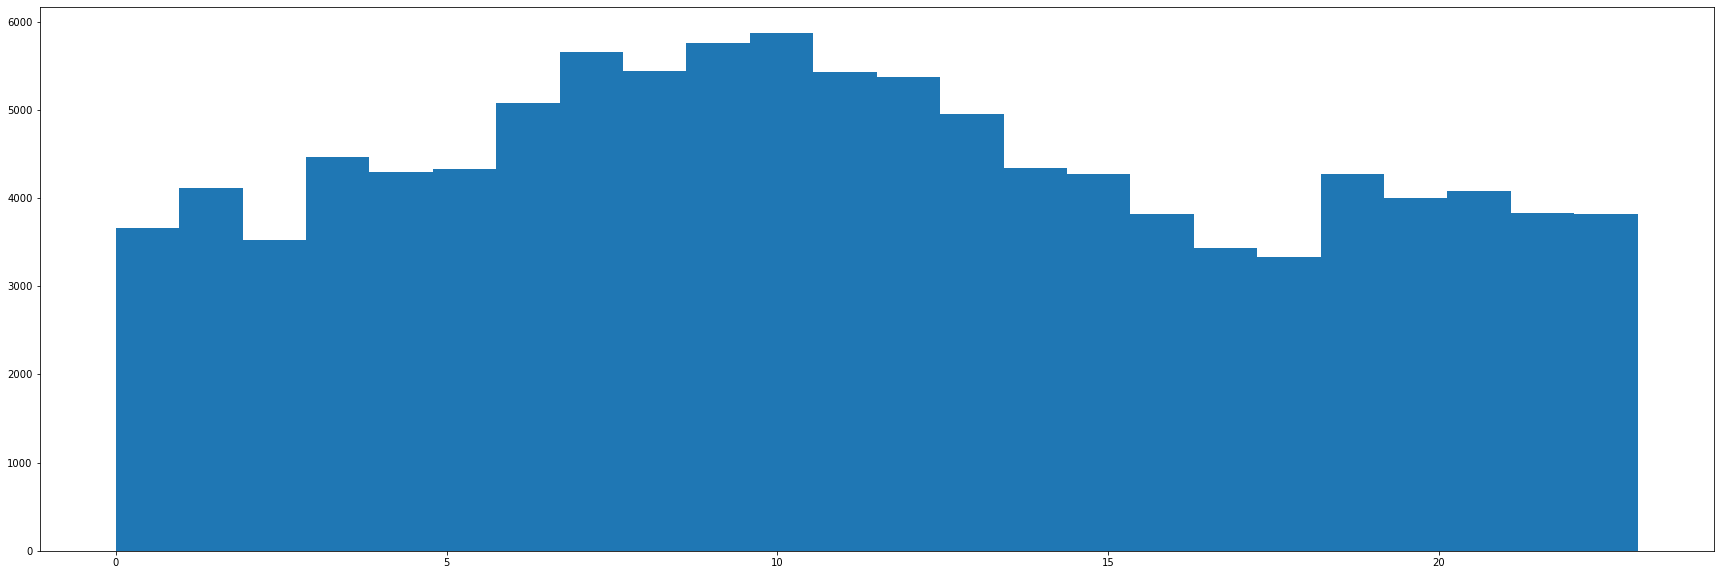

In [372]:
plt.figure(figsize=(30, 10))
plt.hist(date_df.posted_date.map(lambda d: d.hour), bins=24);

In [373]:
date_df['posted_hour'] = date_df.posted_date.map(lambda d: d.hour)

In [398]:
date_df['hour_bucket'] = date_df.posted_hour.map(lambda h: h // 4)

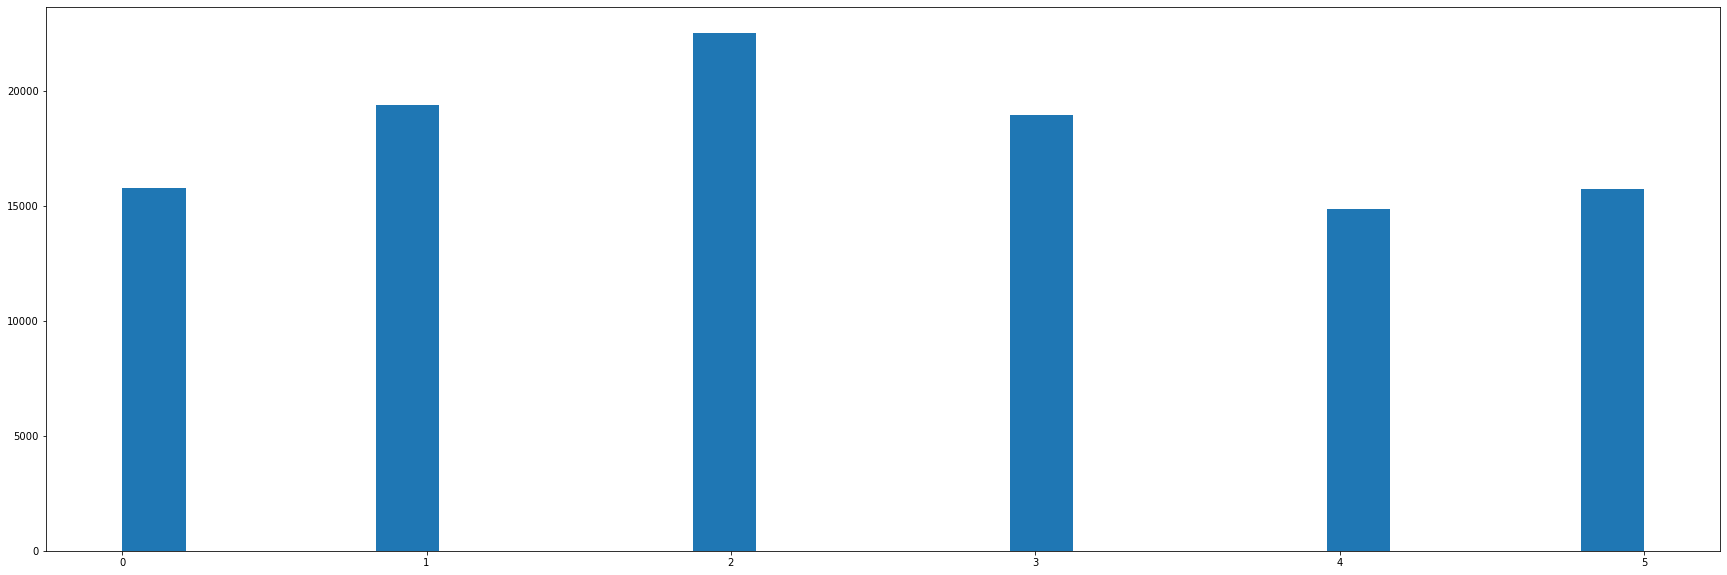

In [399]:
plt.figure(figsize=(30, 10))
plt.hist(date_df.hour_bucket, bins=24);

In [400]:
date_df.groupby('hour_bucket').agg('mean')

,created_utc,num_comments,score,posted_hour
hour_bucket,,,,
0,1.578716e+09,24.423650,19.275265,1.557445
1,1.578684e+09,50.927505,35.231282,5.625123
2,1.578484e+09,45.850793,34.593671,9.502289
3,1.578569e+09,42.635735,24.408604,13.396727
4,1.578662e+09,52.390195,29.073742,17.542393
5,1.578930e+09,33.210315,18.653396,21.474561


In [401]:
date_df[date_df.num_comments > 1].groupby('hour_bucket').agg('mean')

,created_utc,num_comments,score,posted_hour
hour_bucket,,,,
0,1.578302e+09,56.849881,43.659780,1.552319
1,1.578298e+09,105.064813,71.745775,5.621604
2,1.578465e+09,90.310436,67.231904,9.494378
3,1.578556e+09,80.194823,45.039323,13.428771
4,1.578644e+09,96.806311,52.833624,17.513096
5,1.578605e+09,71.013242,38.787850,21.434539


**Group time of day into 6 buckets**

# MVP Plan

Model: Random Forest

Features:
    - hour bucket
    - day of week categorical
    - tone score
    - sentiment
    - facebook comments
    - length of article
    
Dep Var:
    - Number of comments
    - score